<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/Vega_Ferrero_v_Petr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.stats import norm
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import files

В текущей задаче интеграл, которому равна вероятность для отдельной модели, будет выглядеть так: $$P(H_0|D) \propto P(H_0) \ P(D|H_0) \propto P(H_0) \int d \Delta t \ d \mu \cdot p_{lens} (\Delta t, \mu|H_0) \cdot p_{obs} (\Delta t, \mu)$$

where (1) $P(H_0)$ is the prior for $H_0$, 

(2) $p_{lens}(∆t, \mu)$ is the distribution of time delay and magnification predictions of a given lens model (which can be re-scaled to any alternative value of H0), and 

(3) $p_{obs}(∆t, \mu)$ is the ‘observational’ distribution obtained in this work. 

We assume that for each lens model, $p_{lens}(∆t, \mu)$ is described with a normal bivariate distribution (with no correlation between $∆t$ and $\mu$). The mean values and their statistical uncertainties for each image are taken from Table 6 of Treu et al.(2016). Using this approach, we cannot utilize measurements for four images S1-S4 at once to constrain the Hubble parameter, since these images are not independent. Thus, we concentrate on the S2 image as the image with the tightest constraints on the time delay (relative to S1; see Table 4). We include also the SX image since it’s largely independent from S2, even though published data on SX light curve are not enough to place tight constraints. The obtained $P(H_0|D)$ for both S2 and SX for considered here lens models are shown in Figure 12.

Note that in fact the lens models do not contribute equally to the average
posterior distribution. Models with magnification predictions which disagree with our best-fit values are actually down-weighted (see eq. 1). А каким образом?

Contributions of the lens model predictions to $P_+(H0|D)$ obtained as a product of $$p_{lens,i}(∆t_{S2}, \mu_{S2}|H0) \times p_{lens,i}(∆t_{SX}, \mu_{SX}|H0)$$ are shown in Figure 12 (left panel).


Определим несимметричную гауссиану и отдельно её нормировку (внимание, возможно, придётся менять пределы интегрирования при подсчёте площади):

In [0]:
def nonsym_gauss(x, mean, sigma_left, sigma_right):       #поточечно, ненормировано
    
    pdf = 0
        
    if x >= mean:
        pdf = np.exp( - (x - mean)**2/2/sigma_right**2 )
    else:
        pdf = np.exp( - (x - mean)**2/2/sigma_left**2 )
      
    return pdf

def area_nonsym_gauss(mean, sigma_left, sigma_right):

    area_left  =  integrate.quad(lambda t: np.exp( - (t - mean)**2/2/sigma_left**2 ), mean - 5*sigma_left,    mean)
    area_right =  integrate.quad(lambda t: np.exp( - (t - mean)**2/2/sigma_right**2 ), mean, mean + 5*sigma_right)
    
    return area_left[0] + area_right[0]

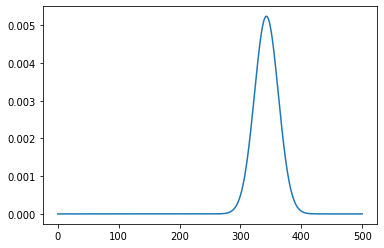

120.31808820351029 0.25738149159368706


In [0]:
xs = np.linspace(0, 500, 501)

pdf=np.zeros(len(xs))

for i in range(0, len(xs)):
    pdf[i] = nonsym_gauss(xs[i], 356, 24, 24)*nonsym_gauss(xs[i], 316, 34, 34)

areaa1 = area_nonsym_gauss(356, 24, 24)
areaa2 = area_nonsym_gauss(356, 24, 24)

plt.plot(xs, pdf/(areaa1+areaa2))
plt.show()

area = sum(pdf/(areaa1+areaa2))*np.diff(xs)[0]

print(areaa1+areaa2, area)

Запишем временную задержку и усиление SX/S1, S2/S1, S3/S1, S4/S1 из наблюдательных данных (нескоррелированных) в модели Петра:

In [0]:
names_images = ['X', '1', '2', '3', '4']

dt_data =             [315.3, 1, 9.6, 4.3, 29.8]
sigma_right_dt_data = [ 59.4, 0, 2.0, 2.3, 7.1 ] 
sigma_left_dt_data =  [ 84.1, 0, 2.2, 2.3, 7.6 ] 

mu_data =             [0.2 , 1, 1.14, 1.01, 0.35] 
sigma_right_mu_data = [0.13, 0, 0.02, 0.02, 0.02] 
sigma_left_mu_data =  [0.06, 0, 0.02, 0.02, 0.01] 

for n in range(len(names_images)):
  print('S', names_images[n], '/S1:', ',   dt:',  dt_data[n], '+', sigma_right_dt_data[n], '-', sigma_left_dt_data[n],
                                      ',   mu:',  mu_data[n], '+', sigma_right_mu_data[n], '-', sigma_left_mu_data[n] )

S X /S1: ,   dt: 315.3 + 59.4 - 84.1 ,   mu: 0.2 + 0.13 - 0.06
S 1 /S1: ,   dt: 1 + 0 - 0 ,   mu: 1 + 0 - 0
S 2 /S1: ,   dt: 9.6 + 2.0 - 2.2 ,   mu: 1.14 + 0.02 - 0.02
S 3 /S1: ,   dt: 4.3 + 2.3 - 2.3 ,   mu: 1.01 + 0.02 - 0.02
S 4 /S1: ,   dt: 29.8 + 7.1 - 7.6 ,   mu: 0.35 + 0.02 - 0.01


Данные моделей из Treu et al.(2015):

In [0]:
names =  ['Gri-g',   'Ogu-g', 'Ogu-a', 'Sha-a', 'Sha-g']
colors = ['orange',  'blue',  'green', 'black', 'indigo']

#SX/S1

dt_X1_model =             [361, 311, 336, 233, 277] #среднее
sigma_right_dt_X1_model = [ 19,  24,  21,  46,  11] #погрешность справа
sigma_left_dt_X1_model =  [ 27,  24,  21,  13,  21] #погрешность слева

mu_X1_model =             [0.36, 0.27, 0.27, 0.19, 0.25] 
sigma_right_mu_X1_model = [0.11, 0.05, 0.03, 0.01, 0.05] 
sigma_left_mu_X1_model =  [0.09, 0.05, 0.03, 0.04, 0.02] 

#S2/S1

dt_21_model =             [10.6,  8.7,  9.4,  8,  6] 
sigma_right_dt_21_model = [ 6.2,  0.7,  1.1,  7,  6] 
sigma_left_dt_21_model =  [ 3.0,  0.7,  1.1,  5,  5] 

mu_21_model =             [0.92, 1.14, 1.15, 0.84, 0.84] 
sigma_right_mu_21_model = [0.43, 0.24, 0.17, 0.20, 0.18] 
sigma_left_mu_21_model =  [0.52, 0.24, 0.17, 0.19, 0.06]

#S3/S1

dt_31_model =             [4.8, 5.1, 5.6,  5, -1] 
sigma_right_dt_31_model = [3.2, 0.5, 0.5, 10,  7] 
sigma_left_dt_31_model =  [1.8, 0.5, 0.5,  7,  5] 

mu_31_model =             [0.99, 1.22, 1.19, 1.46, 1.68] 
sigma_right_mu_31_model = [0.52, 0.24, 0.17, 0.07, 0.55] 
sigma_left_mu_31_model =  [0.33, 0.24, 0.17, 0.49, 0.21]

#S4/S1

dt_41_model =             [25.9, 18.8, 20.9, 17, 12] 
sigma_right_dt_41_model = [8.1 ,  1.7,  2.0,  6, 3 ] 
sigma_left_dt_41_model =  [4.3 ,  1.7,  2.0,  5, 3 ] 

mu_41_model =             [0.42, 0.67, 0.64, 0.44, 0.57] 
sigma_right_mu_41_model = [0.19, 0.17, 0.11, 0.05, 0.11] 
sigma_left_mu_41_model =  [0.20, 0.17, 0.11, 0.10, 0.04]

Проинтегрируем всё вместе:

In [0]:
H_0_fid = 70. #km/s/Mpc
H_0s = np.linspace(20, 200, 1801)

PDFs = np.zeros((len(names), len(H_0s)))

for i in range(0, len(names)):

    P_prom = []
        
    for j in range(0, len(H_0s)):
        
        P_H_0 = 1./len(H_0s)

        image_num = 2     #номер изображения В НАБЛЮДАЕМЫХ ДАННЫХ

        #сначала нормируем, чтобы не интегрировать дополнительно внутри интегрирования

        area_dt_data = area_nonsym_gauss(dt_data[image_num], sigma_left_dt_data[image_num], sigma_right_dt_data[image_num])

        area_mu_data = area_nonsym_gauss(mu_data[image_num], sigma_left_mu_data[image_num], sigma_right_mu_data[image_num])

        area_dt_model = area_nonsym_gauss((H_0_fid/H_0s[j])*dt_21_model[i], sigma_left_dt_21_model[i], sigma_right_dt_21_model[i])

        area_mu_model = area_nonsym_gauss(mu_21_model[i], sigma_left_mu_21_model[i], sigma_right_mu_21_model[i])

        area_full = area_dt_data * area_mu_data * area_dt_model * area_mu_model

        # x - время, y - усиление

        int = integrate.dblquad(lambda y, x: nonsym_gauss(x, dt_data[image_num], sigma_left_dt_data[image_num], sigma_right_dt_data[image_num]) *   #наблюдательные данные
                                           
                                nonsym_gauss(y, mu_data[image_num], sigma_left_mu_data[image_num], sigma_right_mu_data[image_num]) * 
                              
                                nonsym_gauss(x, (H_0_fid/H_0s[j])*dt_21_model[i],                              #данные из моделей
                                             sigma_left_dt_21_model[i], sigma_right_dt_21_model[i]) *
                              
                                nonsym_gauss(y, mu_21_model[i], 
                                             sigma_left_mu_21_model[i], sigma_right_mu_21_model[i]),
                                
                                0, 100, 0, 6 )
        
        
        print(names[i], round(j/len(H_0s), 2), 'H_0 = ', H_0s[j], 'int =', int[0])

        PDFs[i][j] = P_H_0 * int[0] / area_full #тут не забываем про нормировку

Streaming output truncated to the last 5000 lines.
Ogu-a 0.22 H_0 =  60.400000000000006 int = 0.10240104921907342
Ogu-a 0.22 H_0 =  60.5 int = 0.10286170871459903
Ogu-a 0.23 H_0 =  60.6 int = 0.10331664404086935
Ogu-a 0.23 H_0 =  60.7 int = 0.10376584147749124
Ogu-a 0.23 H_0 =  60.800000000000004 int = 0.10420927590019106
Ogu-a 0.23 H_0 =  60.900000000000006 int = 0.10464692888657587
Ogu-a 0.23 H_0 =  61.0 int = 0.10507877870723074
Ogu-a 0.23 H_0 =  61.1 int = 0.10550481341593469
Ogu-a 0.23 H_0 =  61.2 int = 0.10592503084290818
Ogu-a 0.23 H_0 =  61.300000000000004 int = 0.10633940478799637
Ogu-a 0.23 H_0 =  61.400000000000006 int = 0.10674791980833517
Ogu-a 0.23 H_0 =  61.5 int = 0.10715058048892742
Ogu-a 0.23 H_0 =  61.6 int = 0.10754736318467877
Ogu-a 0.23 H_0 =  61.7 int = 0.10793827011128213
Ogu-a 0.23 H_0 =  61.800000000000004 int = 0.10832329460619919
Ogu-a 0.23 H_0 =  61.900000000000006 int = 0.10870242581796463
Ogu-a 0.23 H_0 =  62.0 int = 0.10907566901368167
Ogu-a 0.23 H_0 =  

Сохраним полученные значения в файл (если работа осуществляется не из google colab, то надо закомментить последнюю строчку):

In [0]:
spisok = pd.DataFrame(PDFs).to_csv('Petr_21_PDFs.csv', index=False)

files.download('Petr_21_PDFs.csv')

Подгрузим старые значения (если они уже есть):

In [0]:
uploaded = files.upload()

Saving Petr_21_PDFs.csv to Petr_21_PDFs (1).csv


In [0]:
#dataX = pd.read_csv('Petr_X1_PDFs (1).csv').to_numpy()
data2 = pd.read_csv('Petr_21_PDFs (1).csv').to_numpy()
#data3 = pd.read_csv('Petr_31_PDFs (1).csv').to_numpy()
#data4 = pd.read_csv('Petr_41_PDFs (1).csv').to_numpy()

In [0]:
data_mult = np.zeros((len(names), len(H_0s)))

for i in range(len(names)):
    data_mult[i] = dataX[i] * data2[i]

#data_mult

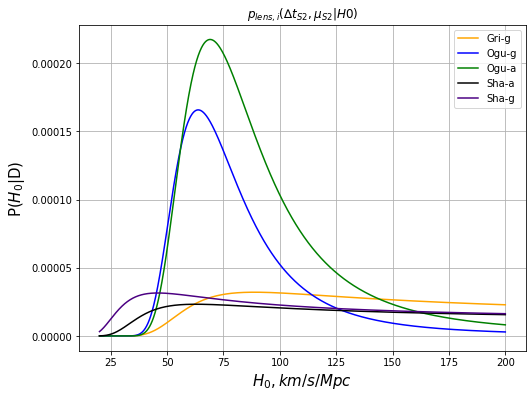

In [0]:
fig = plt.figure(figsize=(8,6))

H_0s = np.linspace(20, 200, 1801)

for i in range(0, len(names)):

    #plt.plot(H_0s, dataX[i][0:], label = names[i], color=colors[i]);  plt.title('$p_{lens,i}(∆t_{SX}, \mu_{SX}|H0)$')
    plt.plot(H_0s, data2[i][0:], label = names[i], color=colors[i]);  plt.title('$p_{lens,i}(∆t_{S2}, \mu_{S2}|H0)$')
    #plt.plot(H_0s, data3[i][0:], label = names[i], color=colors[i]);  plt.title('$p_{lens,i}(∆t_{S3}, \mu_{S3}|H0)$')
    #plt.plot(H_0s, data4[i][0:], label = names[i], color=colors[i]);  plt.title('$p_{lens,i}(∆t_{S4}, \mu_{S4}|H0)$')
    #plt.plot(H_0s, data_mult[i][0:], label = names[i], color=colors[i]);  plt.title('$p_{lens,i}(∆t_{S2}, \mu_{S2}|H0) \ x \ p_{lens,i}(∆t_{SX}, \mu_{SX}|H0)$')
    #plt.plot(H_0s, PDFs[i][0:])

    plt.legend()
    plt.xlabel('$H_0, km/s/Mpc$', fontsize=15)
    plt.ylabel('P($H_0$|D)', fontsize=15)

plt.grid()

plt.savefig('2.png')
files.download('2.png')

plt.show()

#for j in range(len(names)):
#  print(names[j], sum(data4[j][0:])*np.diff(H_0s)[0])


Определим функцию, которая возвращает индексы элементов, соответствующих границам интервала в 68%, вдоль горизонтальной оси:

In [0]:
def f1sb(xs, distribution, percents, plot, Print): #find 1 sigma borders
    
    area = sum(distribution)*np.diff(xs)[0]
    pdf = distribution/area
    cdf = np.cumsum(pdf)*np.diff(H_0s)[0]

    #leftb_perc = (1-percents)/2.
    #rightb_perc = 1-leftb_perc
    
    #middle_ind = np.argmin( np.abs(cdf - .5) )
    
    middle_ind = np.argmax(distribution)

    difference = 100
    
    for ind in range(0, middle_ind):
        
        rind = np.argmin( np.abs( cdf - (cdf[ind] + percents) ) )
        
        difference1 = np.abs( distribution[ind] - distribution[rind] )

        if difference1 <= difference:
            difference = difference1

            left_ind = ind
            right_ind = rind

    leftb_perc = cdf[left_ind]
    rightb_perc = cdf[right_ind]
    
    #left_ind = np.argmin(np.abs(cdf - leftb_perc))
    #right_ind = np.argmin( np.abs(cdf - rightb_perc) )
    
    if plot == True:
        
        plt.plot(H_0s, cdf, 'r:')
        
        plt.axhline(leftb_perc, color='m')
        plt.axhline(rightb_perc, color='m')

        plt.axvline(H_0s[left_ind],  color='g', linestyle = '--')
        plt.axvline(H_0s[right_ind], color='g', linestyle = '--')
        plt.axvline(H_0s[middle_ind],color='g')
    
    if Print == True:
        print('middle index =',middle_ind)
        print('left index =', left_ind)
        print('right index =', right_ind)
        print()
        print('Mean: H_0=', H_0s[middle_ind])
        print('Left border: H_0 =', H_0s[left_ind])
        print('Right border: H_0 =', H_0s[right_ind])
        print('Left sigma =', H_0s[middle_ind] - H_0s[left_ind])
        print('Right sigma =', H_0s[right_ind] - H_0s[middle_ind])

    return middle_ind, left_ind, right_ind

Отдельно перемножим и сложим получившиеся вероятности:

In [0]:
P_sum = np.zeros(len(H_0s))

for i in range(0, len(names)):
    #print(P_mult)
    P_sum = P_sum + data2[i]/(len(names))

midind, leftind, rightind =  f1sb(H_0s, P_sum, .68, plot=0, Print=0)

P_sum_mean        = round(H_0s[midind], 1)
sigma_P_sum_left  = round(H_0s[midind] - H_0s[leftind], 1)  
sigma_P_sum_right = round(H_0s[rightind] - H_0s[midind], 1)

#left = np.quantile(P_sum, 0.16)

#plt.plot(H_0s, P_sum)
#plt.hist(P_sum, density=1)

For P_+(H_0|D):
H_0 = 67.0 + 46.4 - 18.6 (program)


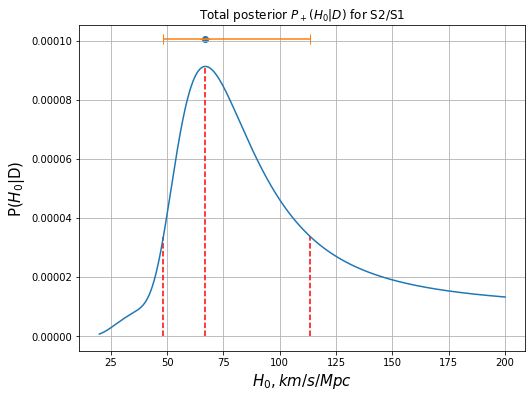

In [0]:
print('For P_+(H_0|D):')
print('H_0 =', P_sum_mean, '+', sigma_P_sum_right, '-', sigma_P_sum_left, '(program)')
#print('H_0 = 71.2 + 16.7 - 11.6 (Petr)')

fig = plt.figure(figsize=(8,6))

plt.grid()
plt.xlabel('$H_0, km/s/Mpc$', fontsize=15)
plt.ylabel('P($H_0$|D)', fontsize=15)
plt.title('Total posterior $P_+(H_0|D)$ for S2/S1')

plt.plot(H_0s, P_sum)#, label = '$P_+(H_0|D)$', linestyle='--')

plt.scatter(P_sum_mean, 1.1*P_sum[np.argmax(P_sum)])
plt.errorbar(P_sum_mean, 1.1*P_sum[np.argmax(P_sum)], 0, [[sigma_P_sum_left], [sigma_P_sum_right]], capsize=5)

plt.vlines(P_sum_mean - sigma_P_sum_left, linestyle = '--',  color = 'r',
           ymin=0, ymax = P_sum[leftind])

plt.vlines(P_sum_mean, linestyle = '--',  color = 'r', ymin=0, ymax=P_sum[midind] )
plt.vlines(P_sum_mean + sigma_P_sum_right, linestyle = '--',  color = 'r',
          ymin=0, ymax = P_sum[rightind])

plt.savefig('H_0 - 2.png')
files.download('H_0 - 2.png')

plt.show()

In [0]:
area = sum(P_sum)*np.diff(H_0s)[0]

area_left = sum(P_sum[0:midind])*np.diff(H_0s)[0]
area_right = area - area_left

area_l = sum(P_sum[0:leftind])*np.diff(H_0s)[0]
area_r = sum(P_sum[0:rightind])*np.diff(H_0s)[0]

all = area_left, area_right, area_l, area_r, area_r-area_l

all/area

array([0.30323776, 0.69676224, 0.06042953, 0.73535274, 0.67492321])